# IMPORTS, FUNCTIONS AND OTHER STATIC STUFF

In [1]:
from lime import our_lime
import os
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from skimage.segmentation import mark_boundaries
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.autograd import Variable
import torch.nn.functional as F
from pycocotools.coco import COCO
from shutil import copy

### SET RANDOM SEEDS FOR COMPARING ###
random.seed(10)
np.random.seed(10)
torch.manual_seed(10)

### STATIC PATHS ###
ROOT_DIR = Path.cwd()
CAT_IMG_PATH = ROOT_DIR / 'data' / 'dogs_vs_cats' / 'predict' / 'cat'
DOG_IMG_PATH = ROOT_DIR / 'data' / 'dogs_vs_cats' / 'predict' / 'dog'
CAT_AND_DOG_IMG_PATH = ROOT_DIR / 'data' / 'dogs_vs_cats' / 'predict' / 'cat_and_dog_in_same_image'
CATVSDOG_CLASSIFIER_WEIGHT_PATH = ROOT_DIR / 'data' / 'dogs_vs_cats' / 'catvdog.pth'
ROOT_DIR = Path.cwd()

classes = ["cat", "dog"]

### COMPUTE DEVICE (CPU/GPU) ###
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

### FUNCTIONS ###
def get_image(path):
    img_path_file = path
    #randomly pick a dog or cat image from image folder
    img_files = list(path.glob('*.jpg*'))
    img_file = random.choice(img_files)
    img_path_file = path / img_file
    with open(os.path.abspath(img_path_file), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB') 
    
#check if paths are valid
if not Path(CAT_IMG_PATH):
    print(f"Warning: The cat image directory was not found:\n{CAT_IMG_PATH}")
if not Path(DOG_IMG_PATH):
    print(f"Warning: The dog image directory was not found:\n{DOG_IMG_PATH}")
if not Path(CATVSDOG_CLASSIFIER_WEIGHT_PATH):
    print(f"Warning: The blackbox classifier weights were not found:\n{BLACKBOX_CLASSIFIER_WEIGHT_PATH}")

Device: cuda


# Demo: ImageObject Class

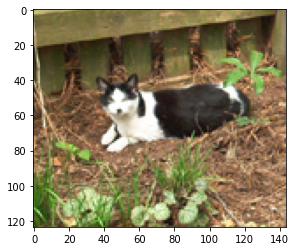

In [2]:
#pick random image
#random_image = get_image(CAT_IMG_PATH)
random_image = get_image(CAT_IMG_PATH)
#random_image = get_image(CAT_AND_DOG_IMG_PATH)

ImageObjectDemo = our_lime.ImageObject(random_image)
ImageObjectDemo.show()

# Image Classifier

In [3]:
#load CatVsDog weights into densenet architecture.
model = models.densenet121(pretrained=False)
model.classifier = nn.Sequential(nn.Linear(1024, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.1),
                                 nn.Linear(256, 2),
                                 nn.LogSoftmax(dim=1))

model.load_state_dict( torch.load(CATVSDOG_CLASSIFIER_WEIGHT_PATH, map_location = device) )

for param in model.parameters():
    param.requires_grad = False

model.eval()

#the data transformation used when training the CatVsDog classifier
def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    

    return transf

preprocess_transform = get_preprocess_transform()


# Demo: Explainer Class

In [4]:
explainer = our_lime.Explainer(
    classifier = model,
    segmentation_method = our_lime.SegmentationMethod("quickshift", kernel_size=4, max_dist=200, ratio=0.2),
    kernel_method = our_lime.KernelMethod("exponential", kernel_width=0.25),
    preprocess_function = preprocess_transform,
    device = device
)
explainer.segment_image(ImageObjectDemo)
#superpixels are saved
ImageObjectDemo.superpixels
print(np.shape(ImageObjectDemo.superpixels))

(124, 144)


# Demo: Generate Mask

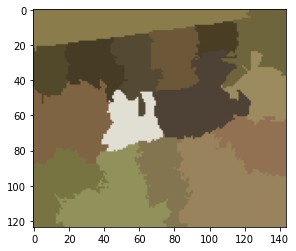

In [5]:
#set mask to to average superpixel value
explainer.mask_image(ImageObjectDemo)
plt.imshow(ImageObjectDemo.masked_image)

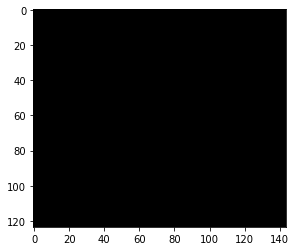

In [6]:
#set mask value to 0
explainer.mask_image(ImageObjectDemo, mask_value = 0)
plt.imshow(ImageObjectDemo.masked_image)

# Demo: Sample Superpixels

In [7]:
#create 3 samples
superpixel_samples, sampled_images = explainer.sample_superpixels(ImageObjectDemo, 4)

<class 'list'>
<class 'numpy.ndarray'>
(124, 144, 3)


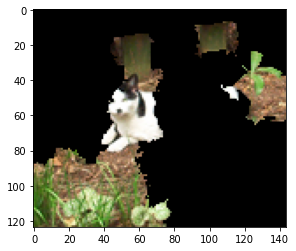

In [8]:
print(type(sampled_images))
#showing first sample
print(type(sampled_images[0]))
print(np.shape(sampled_images[0]))
plt.imshow(sampled_images[0])

# Demo: BlackBox IO

In [9]:
# blackbox output on sampled images
blackbox_out = explainer.map_blaxbox_io(sampled_images)
print(np.mean(blackbox_out, axis=0))
#blackbox output on original image
blackbox_out = explainer.map_blaxbox_io((ImageObjectDemo.original_image,))
print(blackbox_out)



[0.5702697 0.4297303]
[[0.7463519  0.25364807]]


# Demo: Explain Image

Class stats: cat
Intercept:0.696275327237326 R^2:0.3253219516842737 Prediction on ori. image [2.64553113]
Class stats: dog
Intercept:0.3037246960256559 R^2:0.3253219591215948 Prediction on ori. image [-1.64553146]


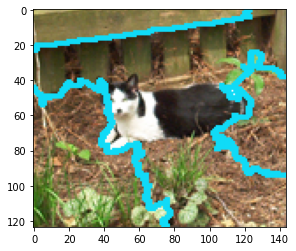

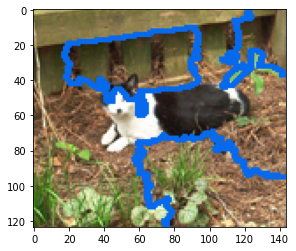

In [10]:
explainer.explain_image(ImageObjectDemo, 200, classes, top_labels = 2, num_superpixels = 10, display = True)


# Get Coco images and annotations for evaluation 

In [11]:
explainer = our_lime.Explainer(
    classifier = model,
    segmentation_method = our_lime.SegmentationMethod("quickshift", kernel_size=4, max_dist=200, ratio=0.2),
    kernel_method = our_lime.KernelMethod("exponential", kernel_width=0.25),
    preprocess_function = preprocess_transform,
    device = device
)
COCO_PATH = ROOT_DIR / 'data' / 'coco' / 'val2017' / 'val2017'
COCO_ANNOTATIONS_PATH = ROOT_DIR / 'data' / 'coco' / 'annotations_trainval2017' / 'annotations' / 'instances_val2017.json'
COCO_TARGET = ROOT_DIR / 'data' / 'coco' / 'images'
dog_binary_masks = explainer.get_coco_data_and_binary_masks(COCO_PATH, COCO_ANNOTATIONS_PATH, COCO_TARGET, 'dog')
cat_binary_masks = explainer.get_coco_data_and_binary_masks(COCO_PATH, COCO_ANNOTATIONS_PATH, COCO_TARGET, 'cat')
COCO_binary_masks = [ cat_binary_masks, dog_binary_masks ]

loading annotations into memory...
Done (t=0.33s)
creating index...
index created!
loading annotations into memory...
Done (t=0.33s)
creating index...
index created!


#  Hyperparameter tuning

In [15]:

### Nsample tuning ###

COCO_DIR = [ROOT_DIR / 'data' / 'coco' / 'images' / 'cat',
            ROOT_DIR / 'data' / 'coco' / 'images' / 'dog']

#nsamples = [i for i in range(1000, 10001, 2000)]
#nsamples = [10000]
nsample_scores = list()

#go through differnt nsamples.
    #compute scores on all dog + cat images. 
    #average all scores.
    #append to nsample_scores

for nsample in nsamples:
    
    print(f"Nsamples: {nsample} for LIME algorithm")
    seg_sizes = list()
    coverages = list()
    for category_dir in COCO_DIR:
        count = 0
        img_files = list(category_dir.glob('*.jpg*'))
        category = os.path.basename(category_dir)
        class_idx = classes.index(category)
        coco_binary_masks = COCO_binary_masks[class_idx]
        print(f"Evaluating category: {category}\nDetected number of images: { len(img_files) }\n")
        
        for img_file in img_files:
            print(f"Evaluating {category} image: { os.path.basename(img_file) }...")
            img_path_file = category_dir / img_file
            with open(os.path.abspath(img_path_file), 'rb') as f:
                with Image.open(f) as img:
                    img.convert('RGB')
            
            img_object = our_lime.ImageObject(img)
            explainer.explain_image(img_object, nsample, classes, num_superpixels = 10)
            LIME_binary_mask = img_object.label_masks[class_idx]
            COCO_binary_mask = coco_binary_masks[os.path.basename(img_file)]
            
            coverage = explainer.coco_evaluation_score_iou(LIME_binary_mask, COCO_binary_mask)
            coverages.append(coverage)
            print(f"LIME_COCO score --> {coverage}")
            
            print("Done.")
    avg_coverage = sum(coverages) / len(coverages)
    print(f"Score when using {nsample} samples ---> {avg_coverage} ")
    nsample_scores.append(avg_coverage)        

nsample_eval_results = list(zip(nsamples, nsample_scores))

Nsamples: 10000 for LIME algorithm
Evaluating category: cat
Detected number of images: 184

Evaluating cat image: 45.jpg...
LIME_COCO coverage --> 0.0010034563496487902
Done.
Evaluating cat image: 59.jpg...
LIME_COCO coverage --> 0.0
Done.
Evaluating cat image: 178.jpg...
LIME_COCO coverage --> 0.23317529512839277
Done.
Evaluating cat image: 77.jpg...
LIME_COCO coverage --> 0.14879729239695394
Done.
Evaluating cat image: 27.jpg...
LIME_COCO coverage --> 0.595702980548776
Done.
Evaluating cat image: 60.jpg...
LIME_COCO coverage --> 0.3631361760660248
Done.
Evaluating cat image: 139.jpg...
LIME_COCO coverage --> 0.15511091779034364
Done.
Evaluating cat image: 140.jpg...
LIME_COCO coverage --> 0.4910743397456798
Done.
Evaluating cat image: 88.jpg...
LIME_COCO coverage --> 0.6974406991260924
Done.
Evaluating cat image: 175.jpg...
LIME_COCO coverage --> 0.48643736017897093
Done.
Evaluating cat image: 79.jpg...
LIME_COCO coverage --> 0.8762945914844649
Done.
Evaluating cat image: 54.jpg...
L

LIME_COCO coverage --> 0.6235239423523943
Done.
Evaluating cat image: 73.jpg...
LIME_COCO coverage --> 0.30208387465571895
Done.
Evaluating cat image: 118.jpg...
LIME_COCO coverage --> 0.5840529416511985
Done.
Evaluating cat image: 8.jpg...
LIME_COCO coverage --> 0.3858351855017952
Done.
Evaluating cat image: 29.jpg...
LIME_COCO coverage --> 0.5626216968011126
Done.
Evaluating cat image: 10.jpg...
LIME_COCO coverage --> 0.669590518163536
Done.
Evaluating cat image: 95.jpg...
LIME_COCO coverage --> 0.2615679935340473
Done.
Evaluating cat image: 120.jpg...
LIME_COCO coverage --> 0.19643290884485928
Done.
Evaluating cat image: 117.jpg...
LIME_COCO coverage --> 0.46890868226088406
Done.
Evaluating cat image: 170.jpg...
LIME_COCO coverage --> 0.315418087733741
Done.
Evaluating cat image: 22.jpg...
LIME_COCO coverage --> 0.032334098875861236
Done.
Evaluating cat image: 92.jpg...
LIME_COCO coverage --> 0.5983653495757197
Done.
Evaluating cat image: 145.jpg...
LIME_COCO coverage --> 0.73559511

LIME_COCO coverage --> 0.5193409742120344
Done.
Evaluating dog image: 48.jpg...
LIME_COCO coverage --> 0.26209977661950856
Done.
Evaluating dog image: 76.jpg...
LIME_COCO coverage --> 0.12945321675583976
Done.
Evaluating dog image: 11.jpg...
LIME_COCO coverage --> 0.38708036622583925
Done.
Evaluating dog image: 100.jpg...
LIME_COCO coverage --> 0.8440555841482243
Done.
Evaluating dog image: 19.jpg...
LIME_COCO coverage --> 0.8594461969856292
Done.
Evaluating dog image: 119.jpg...
LIME_COCO coverage --> 0.7511705981093736
Done.
Evaluating dog image: 146.jpg...
LIME_COCO coverage --> 0.9195603942005056
Done.
Evaluating dog image: 74.jpg...
LIME_COCO coverage --> 0.7427989860972425
Done.
Evaluating dog image: 141.jpg...
LIME_COCO coverage --> 0.1414451261077028
Done.
Evaluating dog image: 153.jpg...
LIME_COCO coverage --> 0.7999598796389168
Done.
Evaluating dog image: 168.jpg...
LIME_COCO coverage --> 0.547768479776848
Done.
Evaluating dog image: 35.jpg...
LIME_COCO coverage --> 0.9363064

LIME_COCO coverage --> 0.027664648688314072
Done.
Evaluating dog image: 9.jpg...
LIME_COCO coverage --> 0.5303300624442462
Done.
Evaluating dog image: 114.jpg...
LIME_COCO coverage --> 0.861644471972747
Done.
Evaluating dog image: 78.jpg...
LIME_COCO coverage --> 0.7393993325917686
Done.
Evaluating dog image: 162.jpg...
LIME_COCO coverage --> 0.9754927521117948
Done.
Evaluating dog image: 131.jpg...
LIME_COCO coverage --> 0.8716711789318238
Done.
Evaluating dog image: 80.jpg...
LIME_COCO coverage --> 0.04599710120214852
Done.
Evaluating dog image: 23.jpg...
LIME_COCO coverage --> 0.02939644970414201
Done.
Evaluating dog image: 2.jpg...
LIME_COCO coverage --> 0.7266684661583103
Done.
Evaluating dog image: 161.jpg...
LIME_COCO coverage --> 0.23550196298373527
Done.
Evaluating dog image: 106.jpg...
LIME_COCO coverage --> 0.8110973426958558
Done.
Evaluating dog image: 126.jpg...
LIME_COCO coverage --> 0.07900531896872988
Done.
Evaluating dog image: 113.jpg...
LIME_COCO coverage --> 0.70764

In [16]:
nsample_eval_results

[(10000, 0.4230737407117962)]

In [14]:
#save results
#filename = ROOT_DIR / 'results' / '1000_and_1500_nsample_results.list' #whatever nsample u running
#outfile = open(filename,'wb')
#pickle.dump(nsample_eval_results, outfile)
#outfile.close()

#HOW to load results
#import pickle
#filename = ROOT_DIR / 'results' / '25_30_nsample_results.list'
#infile = open(filename,'rb')
#results = pickle.load(infile)
#infile.close()
#print(results)

In [12]:
### N superpixel tuning ###

COCO_DIR = [ROOT_DIR / 'data' / 'coco' / 'images' / 'cat',
            ROOT_DIR / 'data' / 'coco' / 'images' / 'dog']

nsuperpixels = [i for i in range(3, 6, 1)]
#nsuperpixels = [10]
nsuperpixels_scores = list()

#go through differnt nsuperpixels.
    #compute score on all dog + cat images. 
    #average all scores.
    #append to nsuperpixels_scores

for nsuperpixel in nsuperpixels:
    
    print(f"Nsuperpixels: {nsuperpixel} for LIME algorithm")
    seg_sizes = list()
    coverages = list()
    for category_dir in COCO_DIR:
        count = 0
        img_files = list(category_dir.glob('*.jpg*'))
        category = os.path.basename(category_dir)
        class_idx = classes.index(category)
        coco_binary_masks = COCO_binary_masks[class_idx]
        print(f"Evaluating category: {category}\nDetected number of images: { len(img_files) }\n")
        
        for img_file in img_files:
            print(f"Evaluating {category} image: { os.path.basename(img_file) }...")
            img_path_file = category_dir / img_file
            with open(os.path.abspath(img_path_file), 'rb') as f:
                with Image.open(f) as img:
                    img.convert('RGB')
            
            img_object = our_lime.ImageObject(img)
            explainer.explain_image(img_object, 900, classes, num_superpixels = nsuperpixel)
            LIME_binary_mask = img_object.label_masks[class_idx]
            COCO_binary_mask = coco_binary_masks[os.path.basename(img_file)]
            
            coverage = explainer.coco_evaluation_score_iou(LIME_binary_mask, COCO_binary_mask)
            coverages.append(coverage)
            print(f"LIME_COCO score --> {coverage}")
            
            print("Done.")
    avg_coverage = sum(coverages) / len(coverages)
    print(f"Score when using {nsuperpixel} superpixels ---> {avg_coverage} ")
    nsuperpixels_scores.append(avg_coverage)        

nsuperpixel_eval_results = list(zip(nsuperpixels, nsuperpixels_scores))

Nsuperpixels: 3 for LIME algorithm
Evaluating category: cat
Detected number of images: 184

Evaluating cat image: 0.jpg...
LIME_COCO coverage --> 0.15733117834234053
Done.
Evaluating cat image: 1.jpg...


KeyboardInterrupt: 

In [ ]:
nsuperpixel_eval_results

In [12]:
### N kernel width tuning ###

COCO_DIR = [ROOT_DIR / 'data' / 'coco' / 'images' / 'cat',
            ROOT_DIR / 'data' / 'coco' / 'images' / 'dog']

#nkernelwidths = np.arange(0.1, 0.6, 0.1)
nkernelwidths = [0.75, 10]
nkernelwidths_scores = list()

#go through differnt nkernelwidths.
    #compute scores on all dog + cat images. 
    #average all scores.
    #append to nsample_scores

for nkernelwidth in nkernelwidths:
    
    print(f"Nkernelwidth: {nkernelwidth} for LIME algorithm")
    
    explainer.kernel_method = our_lime.KernelMethod("exponential", kernel_width=nkernelwidth)
    
    seg_sizes = list()
    coverages = list()
    for category_dir in COCO_DIR:
        count = 0
        img_files = list(category_dir.glob('*.jpg*'))
        category = os.path.basename(category_dir)
        class_idx = classes.index(category)
        coco_binary_masks = COCO_binary_masks[class_idx]
        print(f"Evaluating category: {category}\nDetected number of images: { len(img_files) }\n")
        
        for img_file in img_files:
            print(f"Evaluating {category} image: { os.path.basename(img_file) }...")
            img_path_file = category_dir / img_file
            with open(os.path.abspath(img_path_file), 'rb') as f:
                with Image.open(f) as img:
                    img.convert('RGB')
            
            img_object = our_lime.ImageObject(img)
            explainer.explain_image(img_object, 900, classes, num_superpixels = 11)
            LIME_binary_mask = img_object.label_masks[class_idx]
            COCO_binary_mask = coco_binary_masks[os.path.basename(img_file)]
            
            coverage = explainer.coco_evaluation_score_iou(LIME_binary_mask, COCO_binary_mask)
            coverages.append(coverage)
            print(f"LIME_COCO coverage --> {coverage}")
            
            print("Done.")
    avg_coverage = sum(coverages) / len(coverages)
    print(f"Score when using {nkernelwidth} kernel width ---> {avg_coverage} ")
    nkernelwidths_scores.append(avg_coverage)        

nkernelwidth_eval_results = list(zip(nkernelwidths, nkernelwidths_scores))

Nkernelwidth: 0.75 for LIME algorithm
Evaluating category: cat
Detected number of images: 184

Evaluating cat image: 45.jpg...
LIME_COCO coverage --> 0.002520126006300315
Done.
Evaluating cat image: 59.jpg...
LIME_COCO coverage --> 0.0
Done.
Evaluating cat image: 178.jpg...
LIME_COCO coverage --> 0.12159628308304986
Done.
Evaluating cat image: 77.jpg...
LIME_COCO coverage --> 0.037794299876084264
Done.
Evaluating cat image: 27.jpg...
LIME_COCO coverage --> 0.1748172407743143
Done.
Evaluating cat image: 60.jpg...
LIME_COCO coverage --> 0.26994850819851735
Done.
Evaluating cat image: 139.jpg...
LIME_COCO coverage --> 0.12635518258108414
Done.
Evaluating cat image: 140.jpg...
LIME_COCO coverage --> 0.3809117349519474
Done.
Evaluating cat image: 88.jpg...
LIME_COCO coverage --> 0.23490844278469733
Done.
Evaluating cat image: 175.jpg...
LIME_COCO coverage --> 0.1357114350329729
Done.
Evaluating cat image: 79.jpg...
LIME_COCO coverage --> 0.16013679209134798
Done.
Evaluating cat image: 54.jp

LIME_COCO coverage --> 0.17339577460519537
Done.
Evaluating cat image: 73.jpg...
LIME_COCO coverage --> 0.28606293680434863
Done.
Evaluating cat image: 118.jpg...
LIME_COCO coverage --> 0.12385608731019523
Done.
Evaluating cat image: 8.jpg...
LIME_COCO coverage --> 0.196295671409557
Done.
Evaluating cat image: 29.jpg...
LIME_COCO coverage --> 0.12524599542334097
Done.
Evaluating cat image: 10.jpg...
LIME_COCO coverage --> 0.36803419204847004
Done.
Evaluating cat image: 95.jpg...
LIME_COCO coverage --> 0.20401891252955082
Done.
Evaluating cat image: 120.jpg...
LIME_COCO coverage --> 0.03754508479778989
Done.
Evaluating cat image: 117.jpg...
LIME_COCO coverage --> 0.08832855895464085
Done.
Evaluating cat image: 170.jpg...
LIME_COCO coverage --> 0.16784945017571704
Done.
Evaluating cat image: 22.jpg...
LIME_COCO coverage --> 0.00020257677659833077
Done.
Evaluating cat image: 92.jpg...
LIME_COCO coverage --> 0.14288937175696695
Done.
Evaluating cat image: 145.jpg...
LIME_COCO coverage --> 

LIME_COCO coverage --> 0.16540450683413374
Done.
Evaluating dog image: 14.jpg...
LIME_COCO coverage --> 0.16010689062798245
Done.
Evaluating dog image: 48.jpg...
LIME_COCO coverage --> 0.23636687444345503
Done.
Evaluating dog image: 76.jpg...
LIME_COCO coverage --> 0.11817261302043004
Done.
Evaluating dog image: 11.jpg...
LIME_COCO coverage --> 0.3276112576010332
Done.
Evaluating dog image: 100.jpg...
LIME_COCO coverage --> 0.1746480971177478
Done.
Evaluating dog image: 19.jpg...
LIME_COCO coverage --> 0.2630023358916909
Done.
Evaluating dog image: 119.jpg...
LIME_COCO coverage --> 0.2180001218694778
Done.
Evaluating dog image: 146.jpg...
LIME_COCO coverage --> 0.31402732614126416
Done.
Evaluating dog image: 74.jpg...
LIME_COCO coverage --> 0.29686420776350325
Done.
Evaluating dog image: 141.jpg...
LIME_COCO coverage --> 0.10719013334194298
Done.
Evaluating dog image: 153.jpg...
LIME_COCO coverage --> 0.3911659062226968
Done.
Evaluating dog image: 168.jpg...
LIME_COCO coverage --> 0.19

LIME_COCO coverage --> 0.2770842765668456
Done.
Evaluating dog image: 57.jpg...
LIME_COCO coverage --> 0.28765301139903354
Done.
Evaluating dog image: 33.jpg...
LIME_COCO coverage --> 0.020285176217379606
Done.
Evaluating dog image: 9.jpg...
LIME_COCO coverage --> 0.3338537320664316
Done.
Evaluating dog image: 114.jpg...
LIME_COCO coverage --> 0.2787542034468264
Done.
Evaluating dog image: 78.jpg...
LIME_COCO coverage --> 0.07017044747351539
Done.
Evaluating dog image: 162.jpg...
LIME_COCO coverage --> 0.37168031961844
Done.
Evaluating dog image: 131.jpg...
LIME_COCO coverage --> 0.19608223053225088
Done.
Evaluating dog image: 80.jpg...
LIME_COCO coverage --> 0.05006495916852264
Done.
Evaluating dog image: 23.jpg...
LIME_COCO coverage --> 0.022513980063214197
Done.
Evaluating dog image: 2.jpg...
LIME_COCO coverage --> 0.2241266273297743
Done.
Evaluating dog image: 161.jpg...
LIME_COCO coverage --> 0.09517342631675536
Done.
Evaluating dog image: 106.jpg...
LIME_COCO coverage --> 0.35362

LIME_COCO coverage --> 0.09434404645961837
Done.
Evaluating cat image: 37.jpg...
LIME_COCO coverage --> 0.21721475465714243
Done.
Evaluating cat image: 129.jpg...
LIME_COCO coverage --> 0.16578851673900766
Done.
Evaluating cat image: 103.jpg...
LIME_COCO coverage --> 0.20378756308746585
Done.
Evaluating cat image: 55.jpg...
LIME_COCO coverage --> 0.14261264964722267
Done.
Evaluating cat image: 61.jpg...
LIME_COCO coverage --> 0.06353780829343211
Done.
Evaluating cat image: 72.jpg...
LIME_COCO coverage --> 0.20551384114347748
Done.
Evaluating cat image: 132.jpg...
LIME_COCO coverage --> 0.08539864105196265
Done.
Evaluating cat image: 30.jpg...
LIME_COCO coverage --> 0.04502334543837545
Done.
Evaluating cat image: 84.jpg...
LIME_COCO coverage --> 0.38133711396556436
Done.
Evaluating cat image: 136.jpg...
LIME_COCO coverage --> 0.2927550178718724
Done.
Evaluating cat image: 96.jpg...
LIME_COCO coverage --> 0.1925936449306246
Done.
Evaluating cat image: 3.jpg...
LIME_COCO coverage --> 0.14

LIME_COCO coverage --> 0.2642754662840746
Done.
Evaluating cat image: 52.jpg...
LIME_COCO coverage --> 0.20913791284161654
Done.
Evaluating cat image: 152.jpg...
LIME_COCO coverage --> 0.22825503787797496
Done.
Evaluating cat image: 47.jpg...
LIME_COCO coverage --> 0.24482103638630023
Done.
Evaluating cat image: 101.jpg...
LIME_COCO coverage --> 0.16035385632213128
Done.
Evaluating cat image: 123.jpg...
LIME_COCO coverage --> 0.11258599124452782
Done.
Evaluating cat image: 0.jpg...
LIME_COCO coverage --> 0.18740853567482005
Done.
Evaluating cat image: 53.jpg...
LIME_COCO coverage --> 0.3672266330459672
Done.
Evaluating cat image: 176.jpg...
LIME_COCO coverage --> 0.13267784846732214
Done.
Evaluating cat image: 56.jpg...
LIME_COCO coverage --> 0.12189500640204866
Done.
Evaluating cat image: 149.jpg...
LIME_COCO coverage --> 0.21022799914766674
Done.
Evaluating cat image: 151.jpg...
LIME_COCO coverage --> 0.0016513977902724807
Done.
Evaluating cat image: 7.jpg...
LIME_COCO coverage --> 0

LIME_COCO coverage --> 0.25649122807017544
Done.
Evaluating dog image: 68.jpg...
LIME_COCO coverage --> 0.2074433656957929
Done.
Evaluating dog image: 25.jpg...
LIME_COCO coverage --> 0.23936674033647556
Done.
Evaluating dog image: 156.jpg...
LIME_COCO coverage --> 0.0025888850535036242
Done.
Evaluating dog image: 21.jpg...
LIME_COCO coverage --> 0.28297260960113885
Done.
Evaluating dog image: 172.jpg...
LIME_COCO coverage --> 0.17762746324679388
Done.
Evaluating dog image: 70.jpg...
LIME_COCO coverage --> 0.06065007528119742
Done.
Evaluating dog image: 174.jpg...
LIME_COCO coverage --> 0.1318928273911387
Done.
Evaluating dog image: 89.jpg...
LIME_COCO coverage --> 0.11562899880863081
Done.
Evaluating dog image: 143.jpg...
LIME_COCO coverage --> 0.05418823729101248
Done.
Evaluating dog image: 65.jpg...
LIME_COCO coverage --> 0.05999303510938044
Done.
Evaluating dog image: 13.jpg...
LIME_COCO coverage --> 0.300849963045085
Done.
Evaluating dog image: 155.jpg...
LIME_COCO coverage --> 0.

LIME_COCO coverage --> 0.2780839763503357
Done.
Evaluating dog image: 24.jpg...
LIME_COCO coverage --> 0.1760407816482583
Done.
Evaluating dog image: 167.jpg...
LIME_COCO coverage --> 0.21460186591451508
Done.
Evaluating dog image: 82.jpg...
LIME_COCO coverage --> 0.054795710129825016
Done.
Evaluating dog image: 111.jpg...
LIME_COCO coverage --> 0.20910345142127407
Done.
Evaluating dog image: 97.jpg...
LIME_COCO coverage --> 0.09846789464623859
Done.
Evaluating dog image: 12.jpg...
LIME_COCO coverage --> 0.27804024496937885
Done.
Evaluating dog image: 171.jpg...
LIME_COCO coverage --> 0.19010030053952276
Done.
Evaluating dog image: 32.jpg...
LIME_COCO coverage --> 0.3314327015740443
Done.
Evaluating dog image: 16.jpg...
LIME_COCO coverage --> 0.28547927177012505
Done.
Evaluating dog image: 36.jpg...
LIME_COCO coverage --> 0.39831830790568656
Done.
Evaluating dog image: 124.jpg...
LIME_COCO coverage --> 0.35521131586031374
Done.
Score when using 10 kernel width ---> 0.16730665876367082 

In [13]:
nkernelwidth_eval_results

[(0.75, 0.16855444181019222), (10, 0.16730665876367082)]

# Final Evaluation

In [15]:
#Evaluating LIME with optimal parameters 
#download val 2014  http://images.cocodataset.org/zips/val2014.zip
#download val 2014 annotations http://images.cocodataset.org/annotations/annotations_trainval2014.zip

explainer = our_lime.Explainer(
    classifier = model,
    segmentation_method = our_lime.SegmentationMethod("quickshift", kernel_size=4, max_dist=200, ratio=0.2),
    kernel_method = our_lime.KernelMethod("exponential", kernel_width=0.25),
    preprocess_function = preprocess_transform,
    device = device
)

COCO_PATH = ROOT_DIR / 'data' / 'coco' / 'val2014' / 'val2014'
COCO_ANNOTATIONS_PATH = ROOT_DIR / 'data' / 'coco' / 'annotations_trainval2014' / 'annotations' / 'instances_val2014.json'
COCO_TARGET = ROOT_DIR / 'data' / 'coco' / 'images' / 'final_evaluation'
dog_binary_masks = explainer.get_coco_data_and_binary_masks(COCO_PATH, COCO_ANNOTATIONS_PATH, COCO_TARGET, 'dog')
cat_binary_masks = explainer.get_coco_data_and_binary_masks(COCO_PATH, COCO_ANNOTATIONS_PATH, COCO_TARGET, 'cat')
COCO_binary_masks = [ cat_binary_masks, dog_binary_masks ]

loading annotations into memory...
Done (t=3.53s)
creating index...
index created!
loading annotations into memory...
Done (t=3.10s)
creating index...
index created!


In [16]:
#use optimal hyperparameters and perhaps only evalute on range of images 

num_images_to_evaluate = 100 #perhaps slice number of images as (as there are quite many, 1480 cat and 1521 dog)
coverages = list()
COCO_DIR = [COCO_TARGET / 'cat', COCO_TARGET / 'dog']


for category_dir in COCO_DIR:
    img_files = list(sorted(category_dir.glob('*.jpg*')))[:num_images_to_evaluate]
    category = os.path.basename(category_dir)
    class_idx = classes.index(category)
    coco_binary_masks = COCO_binary_masks[class_idx]
    print(f"Evaluating category: {category}\nEvalutating { len(img_files) } images\n")
        
    for img_file in img_files:
        print(f"Evaluating {category} image: { os.path.basename(img_file) }...")
        img_path_file = category_dir / img_file
        with open(os.path.abspath(img_path_file), 'rb') as f:
            with Image.open(f) as img:
                img.convert('RGB')
            
        img_object = our_lime.ImageObject(img)
#use optimal hyperaparameters here:
        explainer.explain_image(img_object, 900, classes, num_superpixels = 11) # use optimal hyperparameter
        LIME_binary_mask = img_object.label_masks[class_idx]
        COCO_binary_mask = coco_binary_masks[os.path.basename(img_file)]
        coverage = explainer.coco_evaluation_score_iou(LIME_binary_mask, COCO_binary_mask)
        coverages.append(coverage)
        print(f"LIME_COCO coverage --> {coverage}")    
        print("Done.")
avg_coverage = sum(coverages) / len(coverages)
print(f"Score when using optimized hyperparamters ---> {avg_coverage} ")

Evaluating category: cat
Evalutating 100 images

Evaluating cat image: 0.jpg...


KeyboardInterrupt: 

In [ ]:
#save results
filename = ROOT_DIR / 'results' / 'evaluation_results.pickle'
outfile = open(filename,'wb')
pickle.dump(zip(img_files,coverage), outfile)
outfile.close()